In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

In [2]:
import matplotlib as mpl
import seaborn as sns
import locale
# Set to German locale to get comma decimal seperator
# Check with "locale -a" if "de_DE.utf8" is installed on your system
# Installation guide: https://ubuntuforums.org/showthread.php?t=196414
locale.setlocale(
    locale.LC_NUMERIC, "de_DE.utf8")
locale.setlocale(
    locale.LC_TIME, "de_DE.utf8")

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import rgb2hex

# Tell matplotlib to use the locale
plt.rcParams['axes.formatter.use_locale'] = True

# settings

In [3]:
def RGB_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

In [4]:
# Plot parameters
# Style
style = "whitegrid"
# Figure sizes
standard_sizes = {
    "a4portrait": (8.27, 11.69),
    "a4landscape": (11.69, 8.27),
    "a5portrait": (5.8, 8.3),
    "a5landscape": (8.3, 5.8),
}
# Font parameters
font = "Latin Modern Roman"
font_scale = 1.5
# Figure aesthetics
grid_linestyle = "--"
yticks = True
xticks = True
# Colors
palette = sns.color_palette("colorblind")

rgb_grid = (200, 200, 200)
rgb_labels = (0, 0, 0)

hex_grid = RGB_to_hex(*rgb_grid)
hex_labels = RGB_to_hex(*rgb_labels)

palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [5]:
# Set seaborn parameters
rc_theme = {
    "grid.linestyle":grid_linestyle,
    "ytick.left":yticks,
    "xtick.bottom":xticks,
    "ytick.color":hex_grid,
    "ytick.labelcolor":hex_labels,
    "xtick.color":hex_grid,
    "xtick.labelcolor":hex_labels,
    "grid.color":hex_grid,
}

sns.set_theme(
    style=style, font='sans-serif', font_scale=font_scale, palette=palette, rc=rc_theme)

In [6]:
figure_export_as = ["png", "jpg"]
export_dir = "/home/kilian/rli/rl-institut/05_Temp/Kilian/open_bea/plots"

In [7]:
cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

# Heatmaps

In [8]:
base_dir = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/edisgo_files/{}/ego100/dumb/electromobility"

grid_ids = [176, 177, 1056, 1690, 1811, 2534]

file = "charging_processes.csv"

eta_cp = 0.9

len_year = 8760*4
len_week = 672

In [9]:
def generate_weekly_heatmap(
    df, xtick_stepsize=16, xlabel="Uhrzeit",
    colorbar_title="Leistung in MW", fname=""):
    
    fig, ax = plt.subplots(
        1, 1, figsize=standard_sizes["a5landscape"])
    
    # the index of the position of yticks
    xticks = np.arange(0, 95, xtick_stepsize)
    # the content of labels of these yticks
    xticklabels = [df.columns[idx] for idx in xticks]
    
    sns.heatmap(
        heatmap_df, cmap=cmap, ax=ax, xticklabels=xticklabels,
        cbar_kws={
            "label": colorbar_title})
    
    # ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45, ha="right")
    
    # labels
    ax.set_xlabel(xlabel)
    
    plt.tight_layout()
    
    for kind in figure_export_as:
        plt.savefig(
            os.path.join(export_dir, f"{fname}.{kind}"),
            dpi=450, bbox_inches="tight")
    
    plt.show()

  0%|                                                                                           | 0/6 [00:00<?, ?it/s]

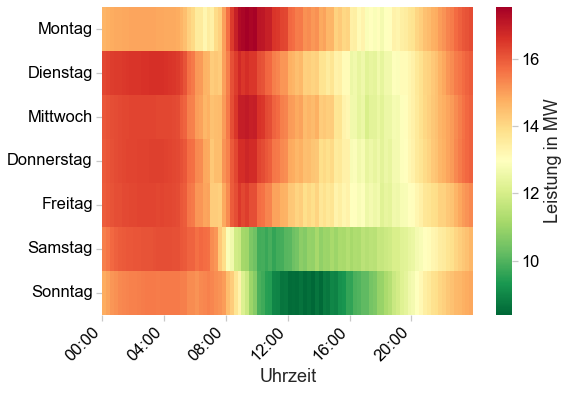

 17%|█████████████▊                                                                     | 1/6 [00:32<02:41, 32.21s/it]

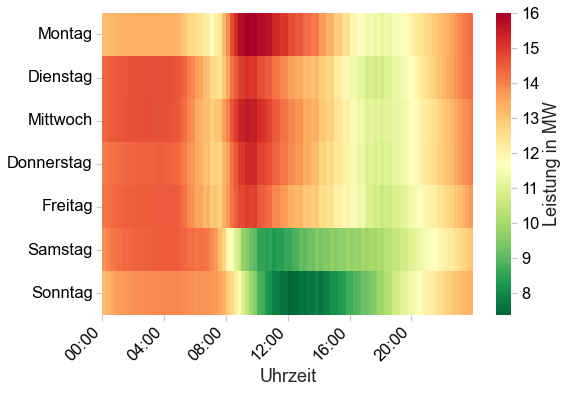

 33%|███████████████████████████▋                                                       | 2/6 [01:01<02:00, 30.20s/it]

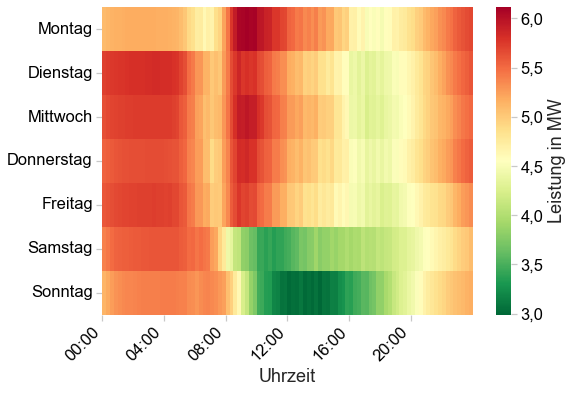

 50%|█████████████████████████████████████████▌                                         | 3/6 [01:14<01:07, 22.42s/it]

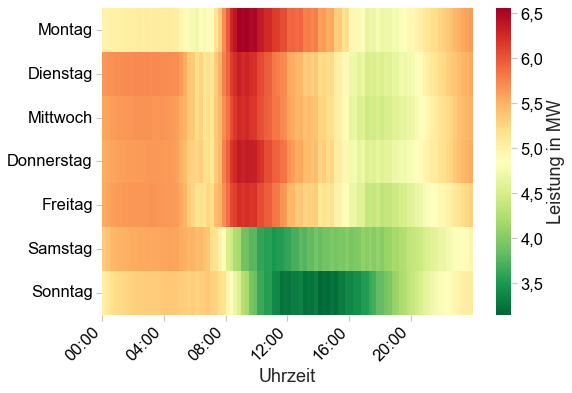

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [01:25<00:36, 18.09s/it]

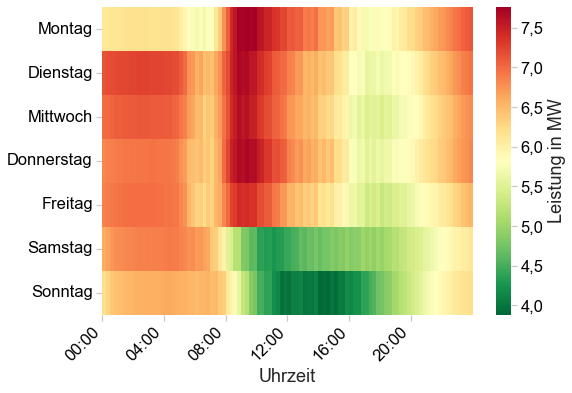

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [01:39<00:16, 16.59s/it]

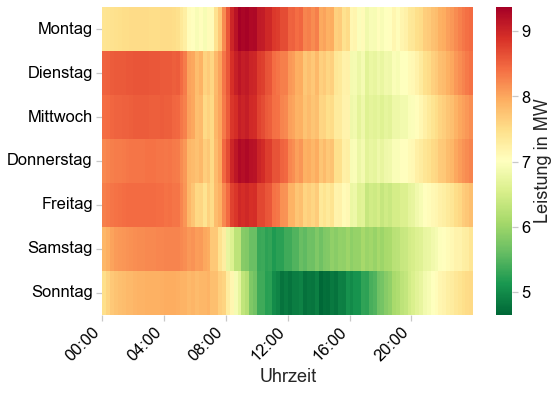

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.05s/it]


In [10]:
fname = "{}_mean_shiftable_power"

for grid_id in tqdm(grid_ids):
    grid_dir = Path(base_dir.format(grid_id))
    
    cp_df = pd.read_csv(os.path.join(
        grid_dir, file), index_col=0)
    
    private_cp_df = cp_df.loc[cp_df.use_case == "private"]
    private_cp_df = private_cp_df.assign(
        minimum_charging_time=(private_cp_df.chargingdemand / private_cp_df.netto_charging_capacity.divide(4)).apply(
            np.ceil).astype(int),
        given_time=private_cp_df.park_end - private_cp_df.park_start,
        brutto_charging_capacity=private_cp_df.netto_charging_capacity / eta_cp)

    flex_cp_df = private_cp_df.loc[
        (private_cp_df.minimum_charging_time < private_cp_df.given_time) &
        (private_cp_df.park_start < len_year)]
    
    dummy_ts = np.zeros(flex_cp_df.park_end.max())
    
    for _, start, stop, cap in flex_cp_df[["park_start", "park_end", "brutto_charging_capacity"]].itertuples():
        dummy_ts[start:stop] += cap
        
    timeseries = pd.DataFrame(
        data=dummy_ts[:len_year], index=pd.date_range(
            start="2018-01-01", periods=len_year, freq="15Min"),
        columns=["shiftable_power"])
    
    mean_timeseries = []

    for timestep in range(len_week):
        mean_timeseries.append(
            timeseries[timestep::len_week].mean().mean())
        
    mean_ts = pd.DataFrame(
        data=mean_timeseries, index=pd.date_range(
            start="2018-01-01", periods=len_week, freq="15Min"),
        columns=["mean_shiftable_power"])
    
    heatmap_df = pd.DataFrame()

    for i in range(7):
        day_ts = mean_ts.iloc[int(i*672/7):int((i+1)*672/7)].T

        day_ts.index = [day_ts.columns[0].strftime("%A")]

        day_ts.columns = [date.strftime("%H:%M") for date in pd.date_range(
            "2018-01-01", periods=day_ts.shape[1], freq="15Min")]

        heatmap_df = heatmap_df.append(day_ts)

    heatmap_df = heatmap_df.divide(1000)
    
    generate_weekly_heatmap(heatmap_df, fname=fname.format(grid_id))
    

# Curtailment Results

### VRES

In [11]:
base_dir = ("/home/kilian/rli/PC50/storage/open_bea_calculations_v4"
            "/{}/{}/ego100/{}")

curtailment_dirs = ["curtailment_results_weekly", "curtailment_results_weekly_with_solar_storage"]

weeks = ["max_rl", "min_rl"]
                    
strategies = ["dumb", "reduced", "residual"]

scenario_tuples = [
    (curtailment_dir, grid_id, strategy, week)
    for curtailment_dir in curtailment_dirs for grid_id in grid_ids
    for strategy in strategies for week in weeks]

file = "{}_curtailment_ts_per_gen.csv"

topo_dir = ("/home/kilian/rli/PC50/storage/open_bea_calculations_v4"
            "/edisgo_files/{}/ego100/{}/topology")

topo_file = "generators.csv"

In [12]:
vres = ["solar", "wind"]

idx = pd.IndexSlice

results_df = pd.DataFrame(
    index=[*range(672)], columns=pd.MultiIndex.from_tuples(scenario_tuples))

for curtailment_dir, grid_id, strategy, week in tqdm(scenario_tuples):
    # data dirs
    cur_dir = base_dir.format(
        curtailment_dir, grid_id, strategy)
    topo_grid_dir = topo_dir.format(
        grid_id, strategy)
    
    # curtailment file
    cur_f = file.format(week)
    
    cur_df = pd.read_csv(os.path.join(
        cur_dir, cur_f), index_col=0, parse_dates=True)
    
    topo_df = pd.read_csv(os.path.join(
        topo_grid_dir, topo_file), index_col=0)
    
    vres_gen = topo_df.loc[
        topo_df.type.isin(vres)].index
    
    cur_s = cur_df[vres_gen].sum(axis=1).tolist()
    
    results_df.loc[
        :, idx[curtailment_dir, grid_id, strategy, week]] = cur_s

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:21<00:00,  3.32it/s]


In [13]:
title_dict = {
    "curtailment_results_weeklydumb": "Ungesteuert",
    "curtailment_results_weeklyreduced": "Reduziert",
    "curtailment_results_weeklyresidual": "Residual",
    "curtailment_results_weekly_with_solar_storagedumb": "Ungesteuert\nmit ESS",
    "curtailment_results_weekly_with_solar_storagereduced": "Reduziert\nmit ESS",
    "curtailment_results_weekly_with_solar_storageresidual": "Residual\nmit ESS"}

In [14]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def colormap_darkred_white_green():
    rgb_1 = cm.get_cmap("gist_heat")
    x = np.linspace(0.1, 0.8, 40)
    rgb_list_1 = rgb_1(x)
    rgb_2 = cm.get_cmap("YlGn")
    x = np.linspace(0.3, 1.0, 40)
    rgb_list_2 = rgb_2(x)
    rgb_list = np.concatenate((rgb_list_1,
                               np.array([[1, 1, 1, 1]]),
                               np.array([[1, 1, 1, 1]]),
                               np.array([[1, 1, 1, 1]]),
                               rgb_list_2))
    cmap_name = 'my_list'
    cm_me = LinearSegmentedColormap.from_list(
        cmap_name, rgb_list, N=100)
    return cm_me

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


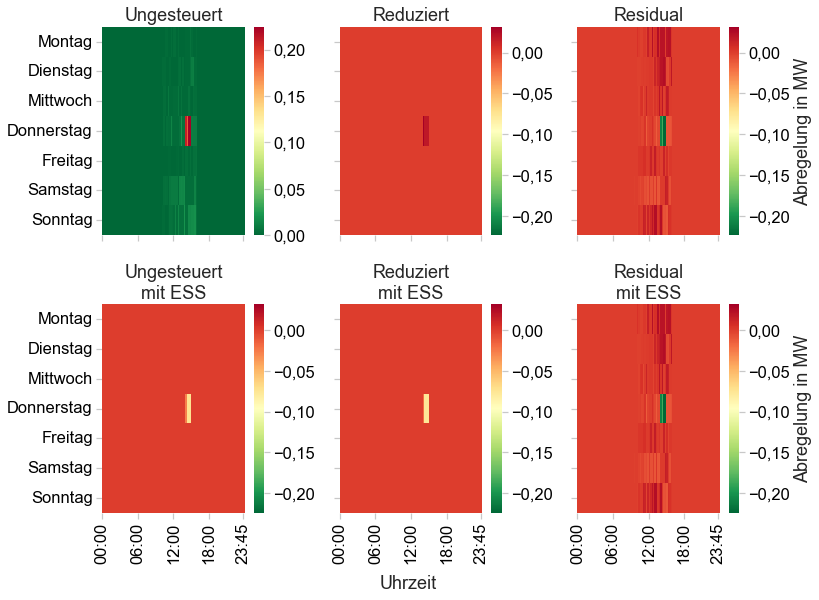

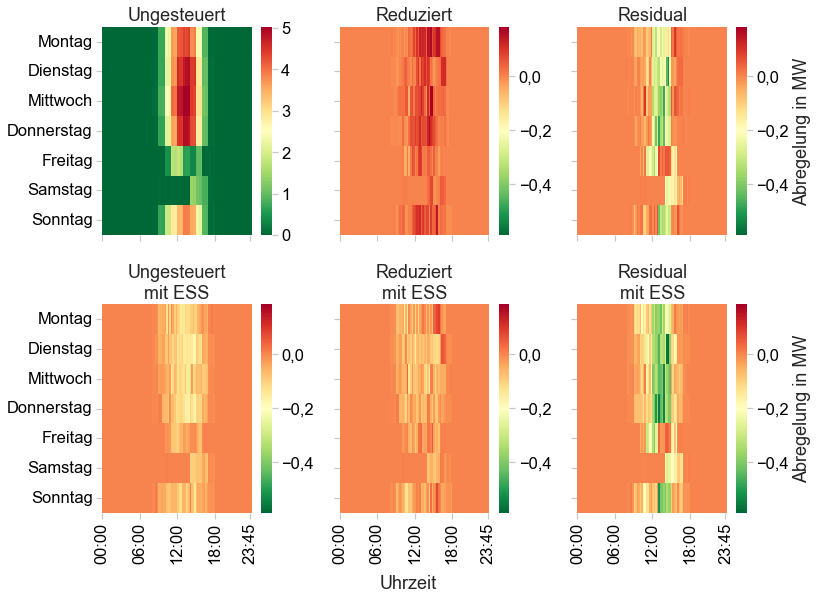

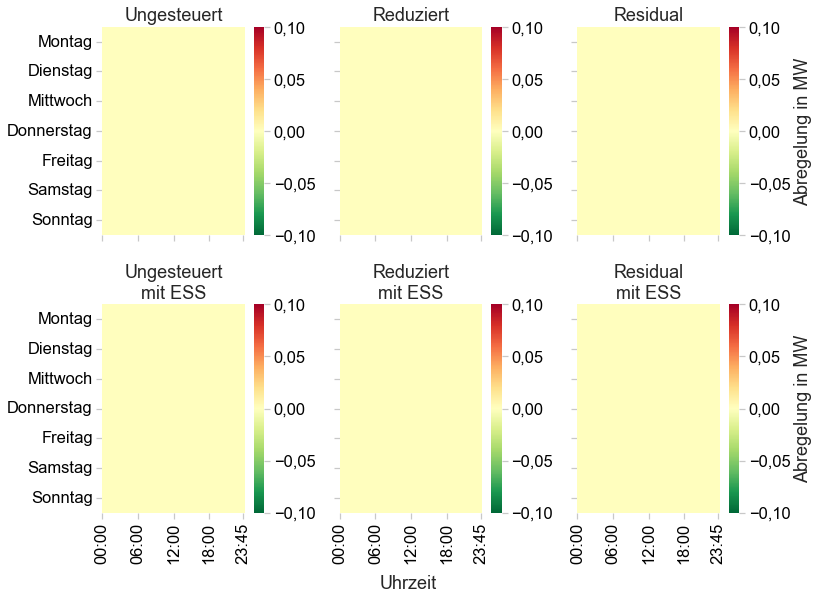

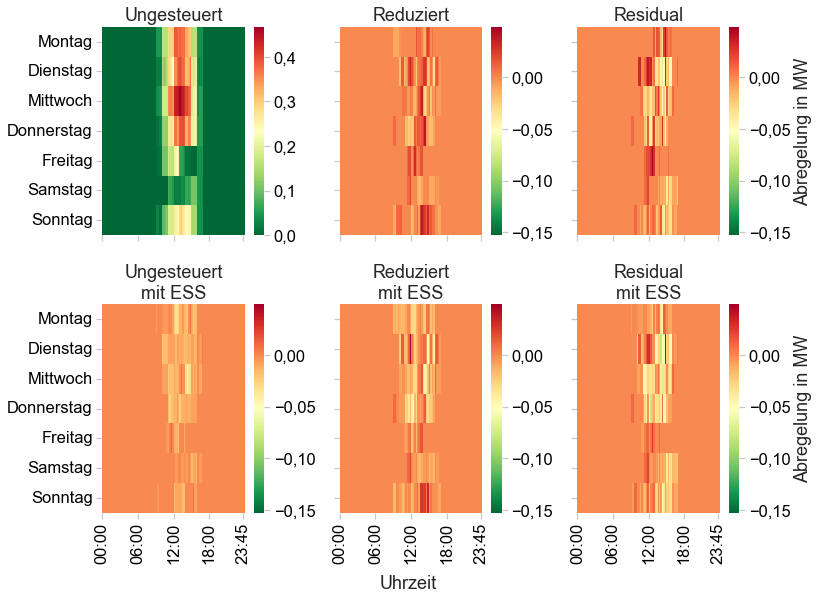

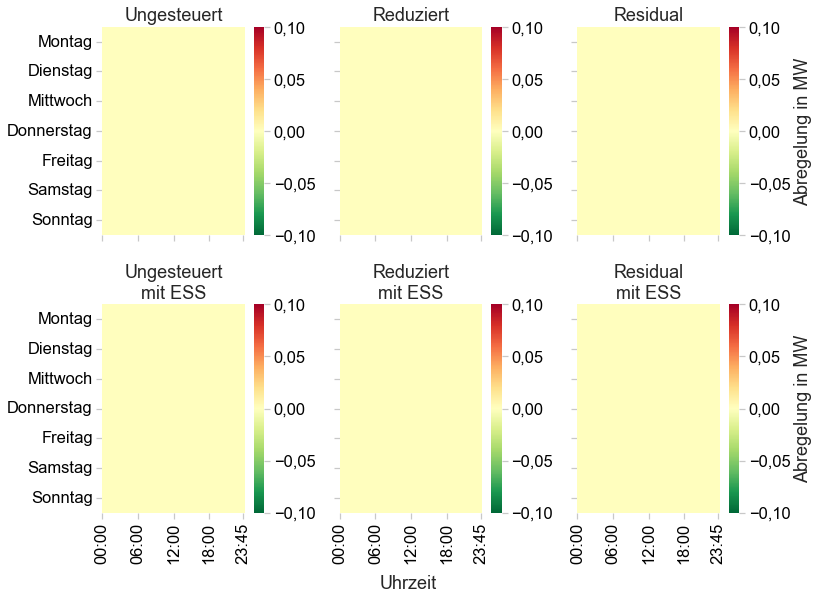

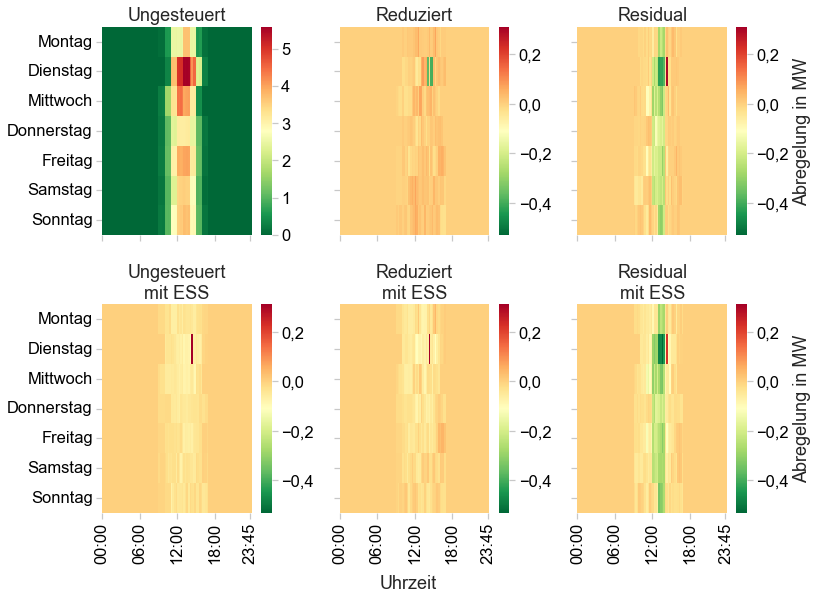

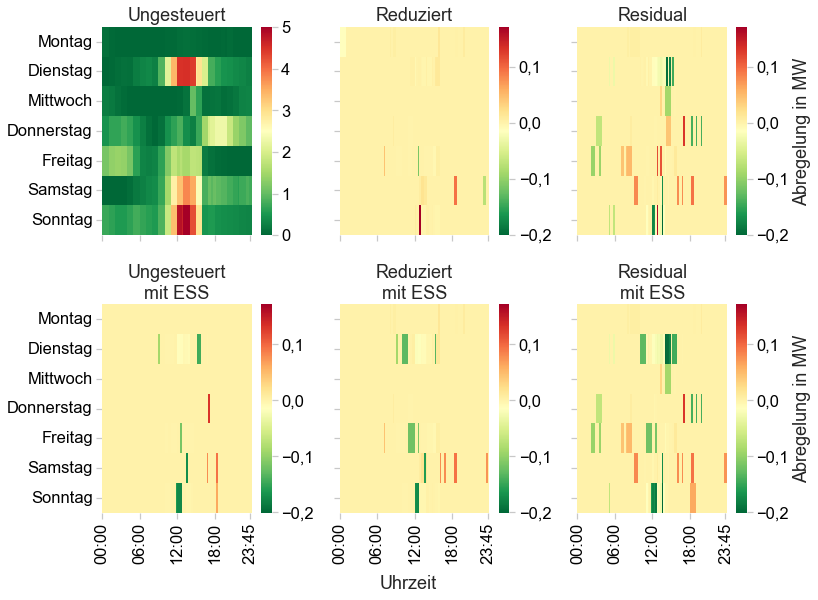

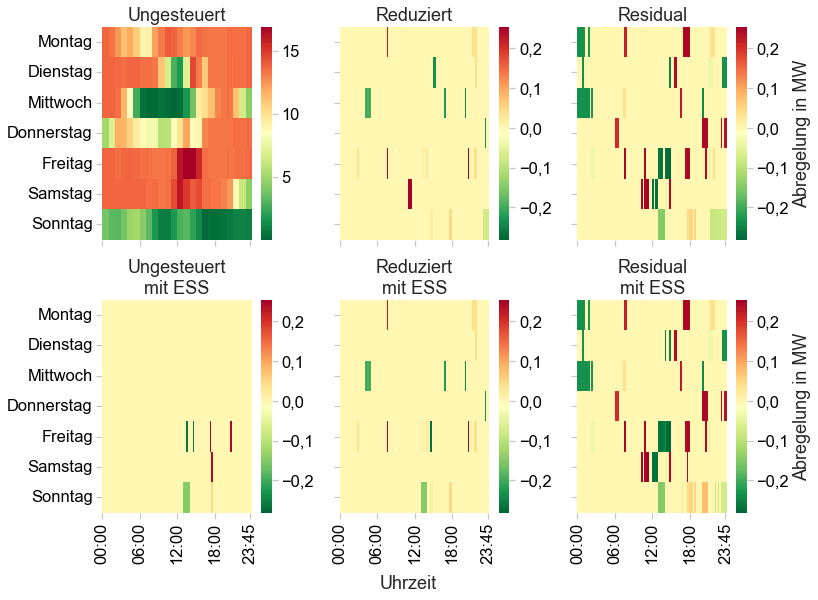

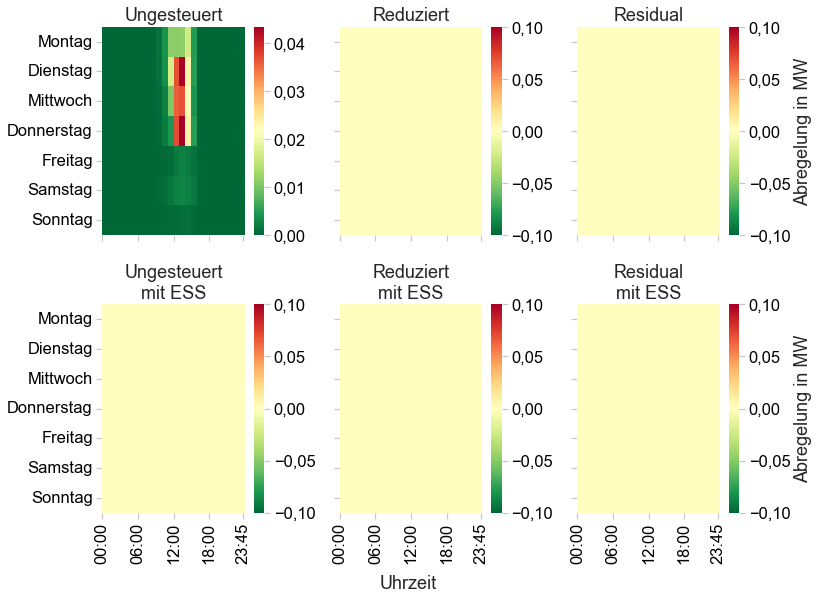

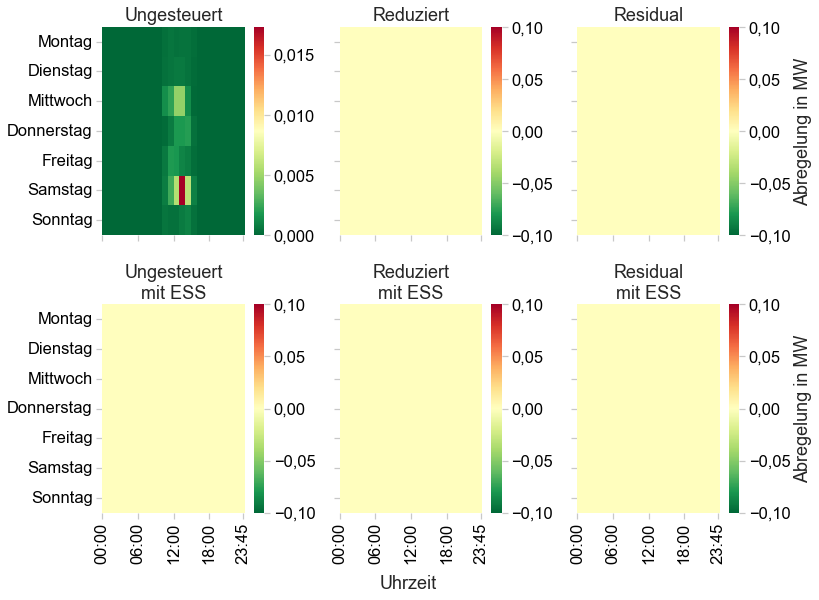

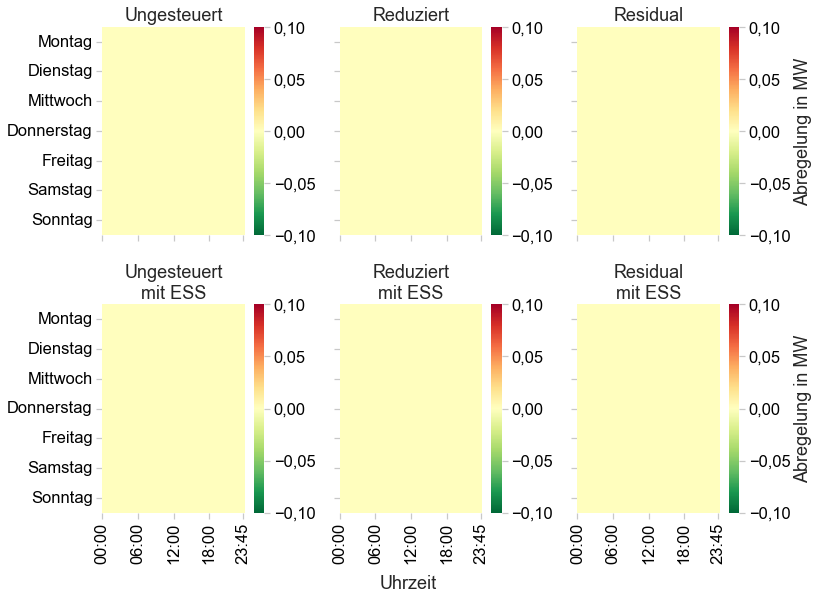

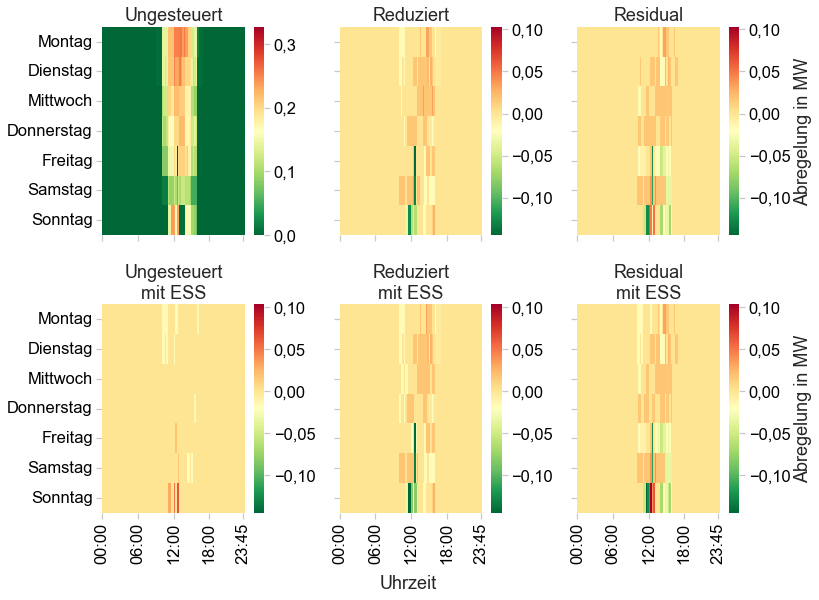

In [15]:
plot_tuples = [
    (curtailment_dir, strategy)
    for curtailment_dir in curtailment_dirs
    for strategy in strategies]

index = pd.date_range("2018-01-01", periods=7, freq="1D")
index = [ts.strftime("%A") for ts in index]

columns = [date.strftime("%H:%M") for date in pd.date_range(
            "2018-01-01", periods=96, freq="15Min")]

for grid_id in grid_ids:
    grid_df = results_df.loc[:, idx[:, grid_id, :, :]]
    
    base_case_sli = grid_df.iloc[:, :2].to_numpy()
    
    grid_df.iloc[:, 2:] -= np.tile(
        grid_df.iloc[:, :2].to_numpy(), (1, 5))
    
    for week in weeks:
        week_df = grid_df.loc[
            :, idx[:, :, :, week]]

        fig, axs = plt.subplots(
            2, 3, figsize=standard_sizes["a4landscape"], sharex=True, sharey=True)
        
        vmin = min(week_df.iloc[:, 1:].min().min(), 0)
        vmax = max(week_df.iloc[:, 1:].max().max(), 0)

        x = 0
        y = 0

        for count, (curtailment_dir, strategy) in enumerate(plot_tuples):
            plot_arr = week_df.loc[
                :, idx[curtailment_dir, :, strategy, :]].to_numpy().reshape(7, int(672/7))
            
            plot_df = pd.DataFrame(
                plot_arr, index=index, columns=columns)

            ax = axs[y, x]
                        
            # the index of the position of yticks
            xticks = [0, 24, 48, 72, 95]
            # the content of labels of these yticks
            xticklabels = [plot_df.columns[idx] for idx in xticks]
            
            if x == 2:
                colorbar_title = "Abregelung in MW"
            else:
                colorbar_title = None
            
            if count == 0:
                sns.heatmap(
                    plot_df, cmap=cmap, ax=ax, xticklabels=xticklabels,
                    cbar_kws={
                        "label": colorbar_title})
            else:
                sns.heatmap(
                    plot_df, cmap=cmap,
                    ax=ax, xticklabels=xticklabels,
                    vmin=vmin, vmax=vmax,
                    cbar_kws={
                        "label": colorbar_title})

            # ticks
            ax.set_xticks(xticks)
            ax.set_xticklabels(
                xticklabels, rotation=90, ha="center")

            # title
            ax.set_title(
                title_dict[curtailment_dir + strategy])

            if x == 2:
                x = 0
                y += 1
            else:
                x += 1
                
        fig.text(0.5, -0.01, "Uhrzeit", ha='center')

        plt.tight_layout()
        
        for kind in figure_export_as:
            plt.savefig(
                os.path.join(export_dir, f"{grid_id}_{week}_fee_curtailment_heatmap.{kind}"),
                dpi=450, bbox_inches="tight")

        plt.show()
        

# Line Plots

In [ ]:
from matplotlib.colors import ListedColormap

## VRES

In [17]:
legend_dict = {
    "curtailment_results_weeklydumb": "Ungesteuert",
    "curtailment_results_weeklyreduced": "Reduziert",
    "curtailment_results_weeklyresidual": "Residual",
    "curtailment_results_weekly_with_solar_storagedumb": "Ungesteuert mit ESS",
    "curtailment_results_weekly_with_solar_storagereduced": "Reduziert mit ESS",
    "curtailment_results_weekly_with_solar_storageresidual": "Residual mit ESS"}

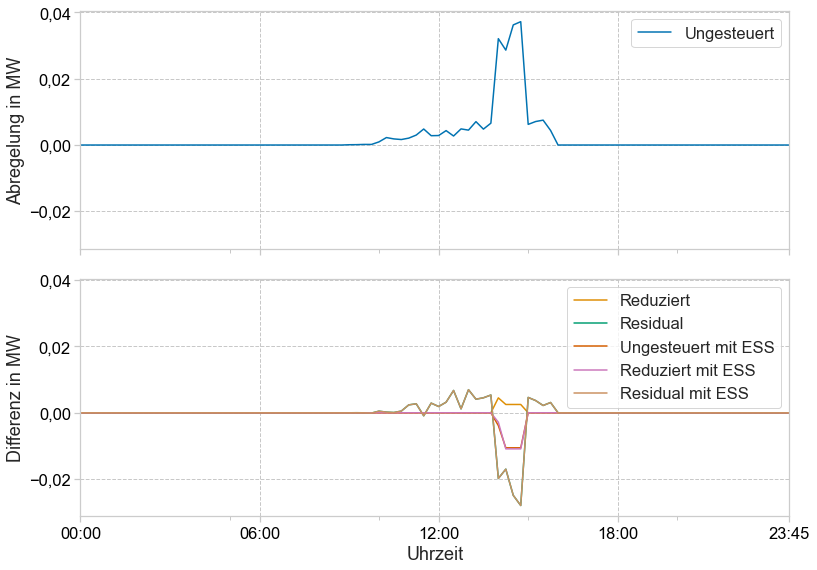

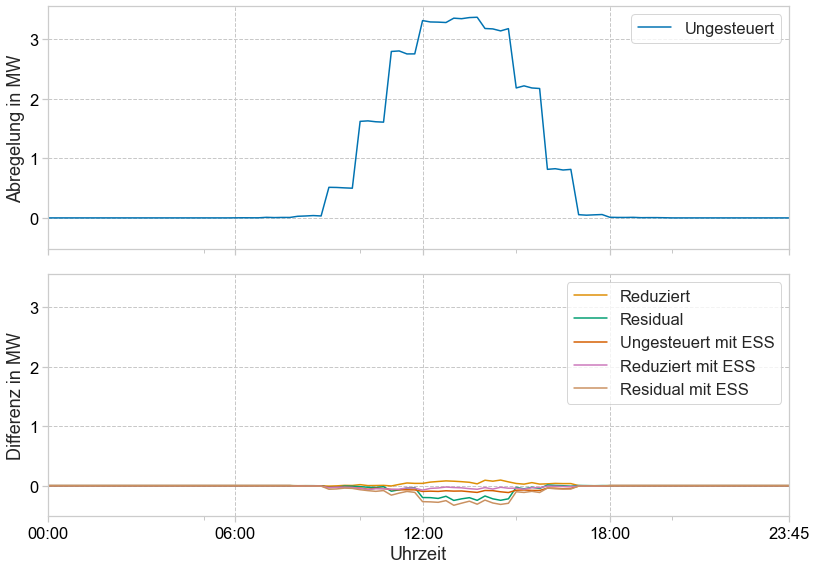

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


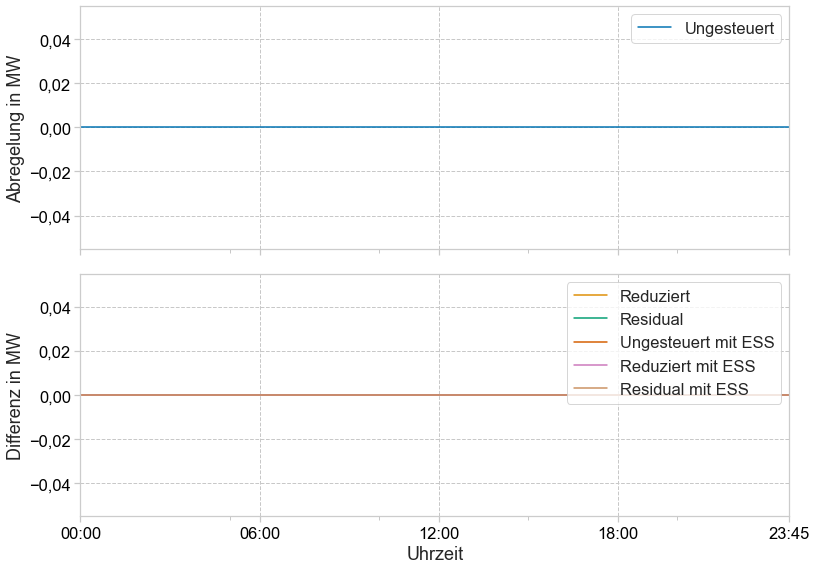

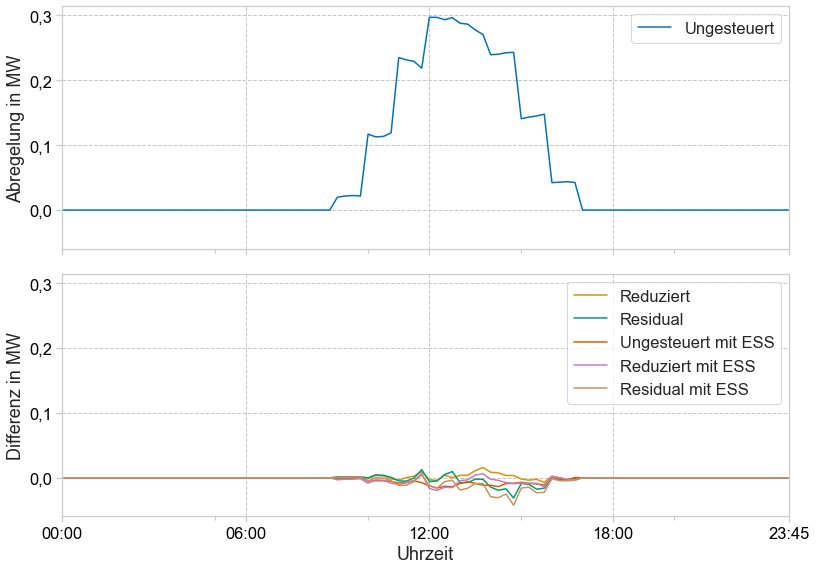

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


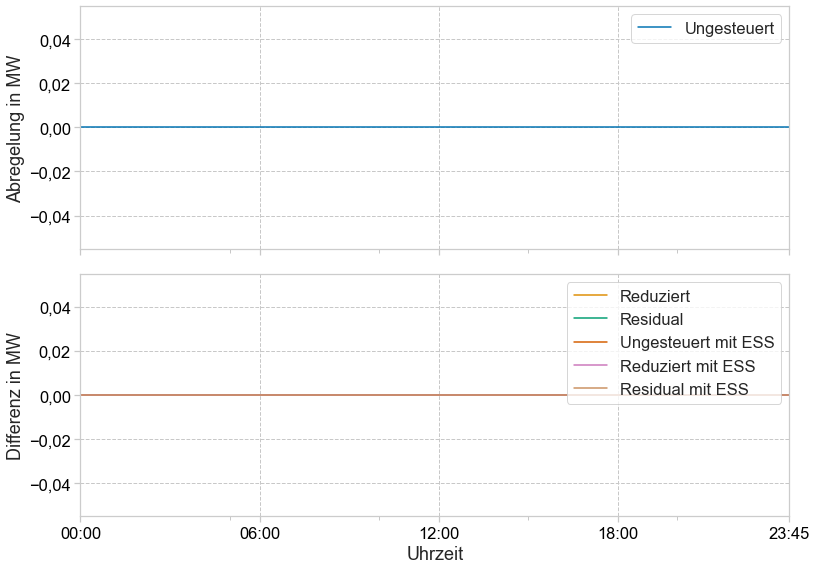

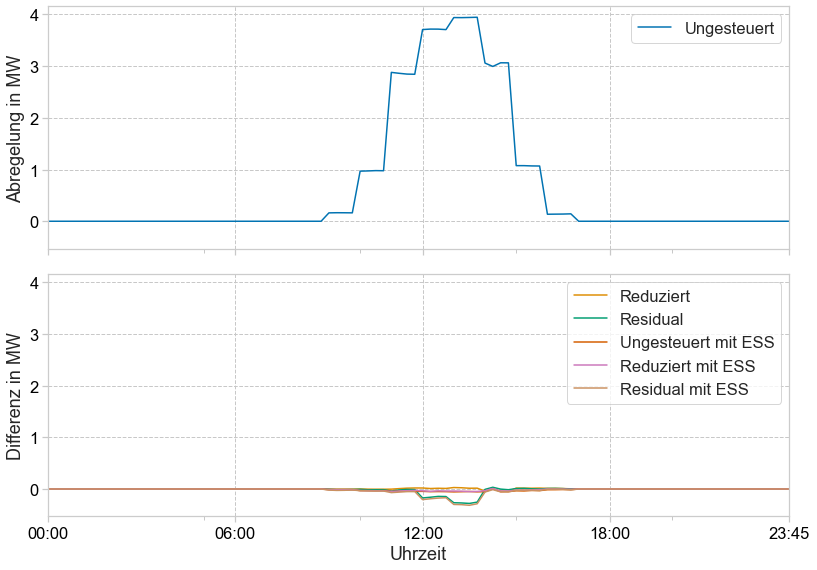

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


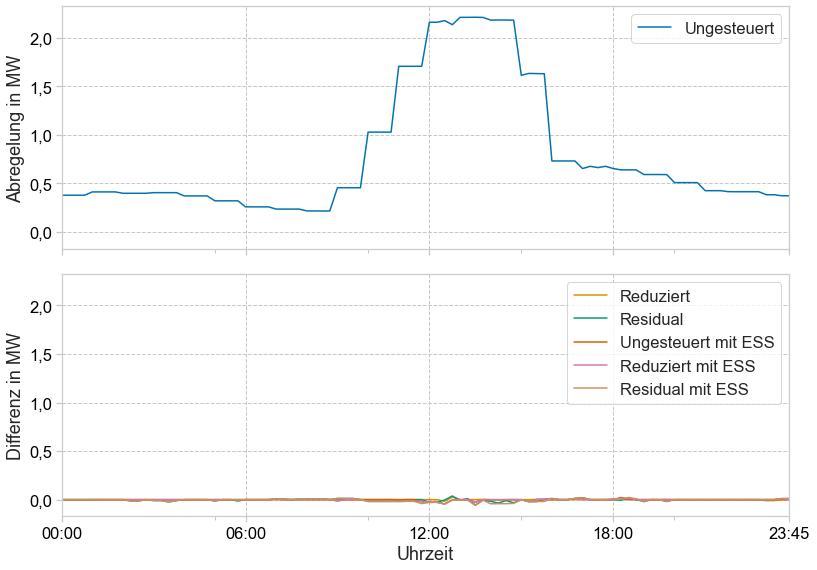

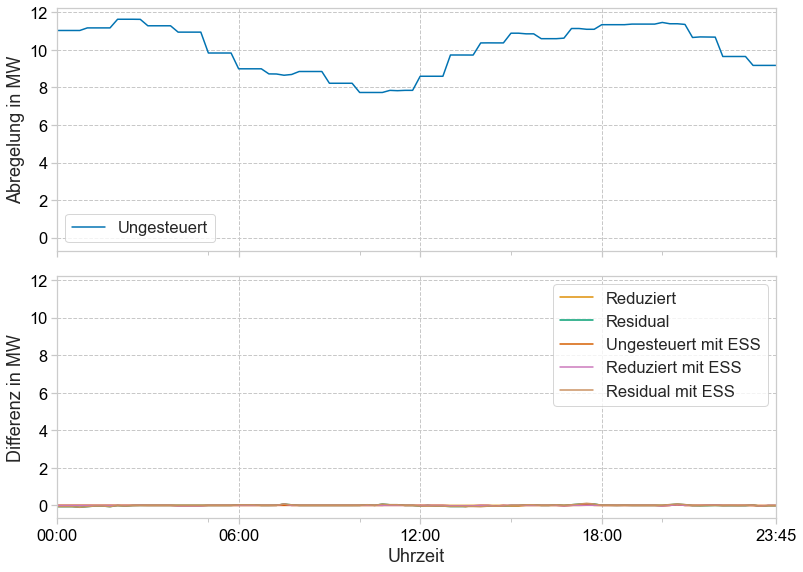

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


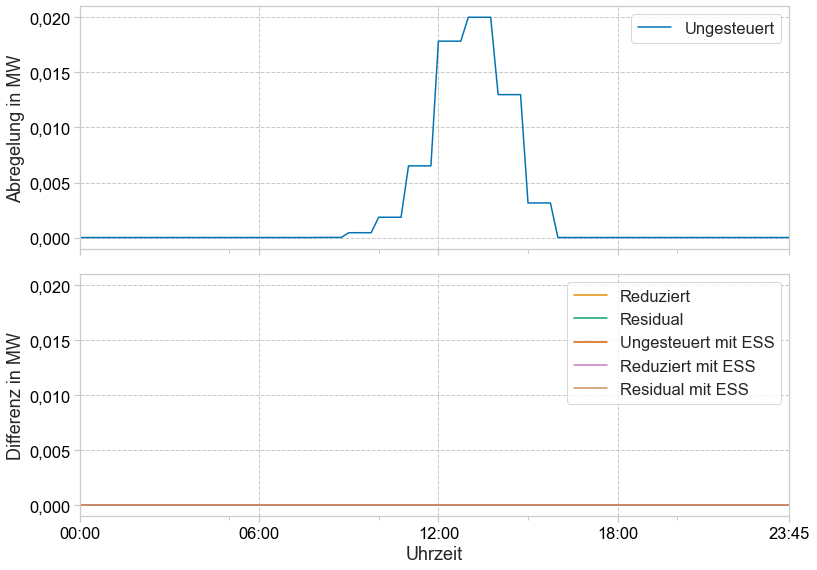

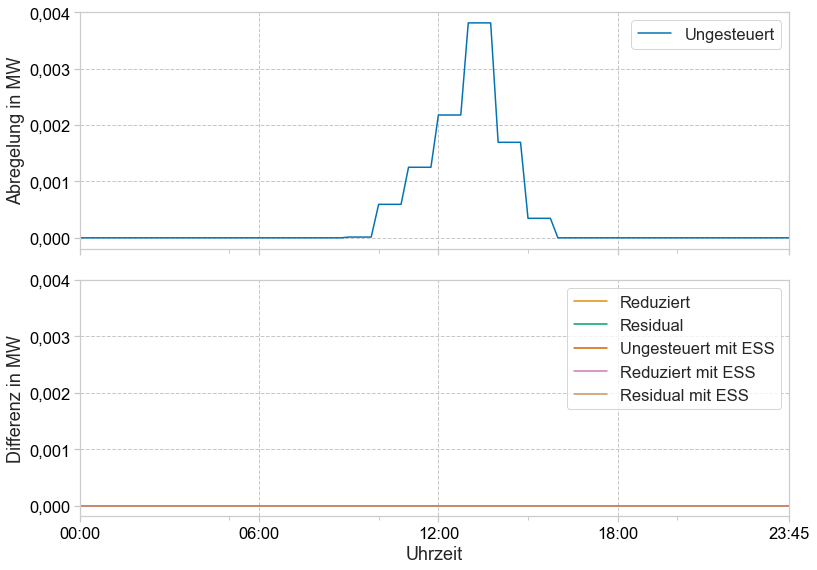

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


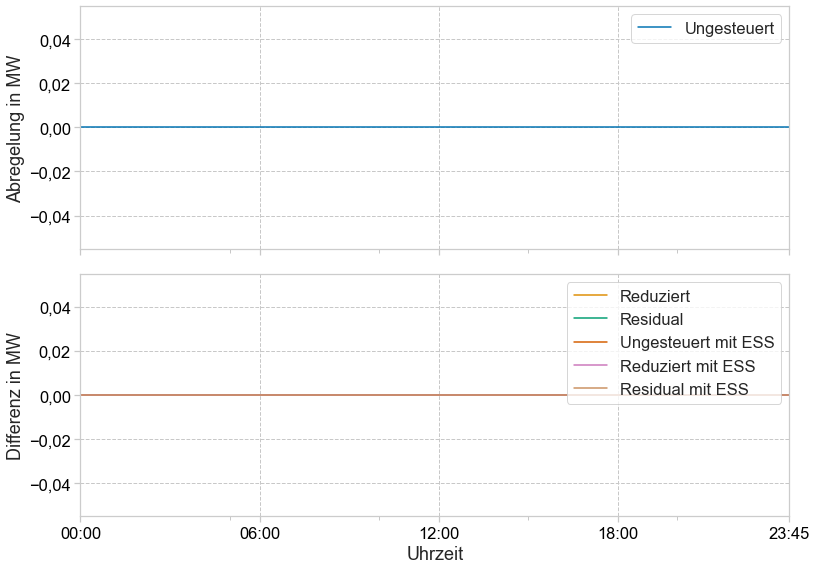

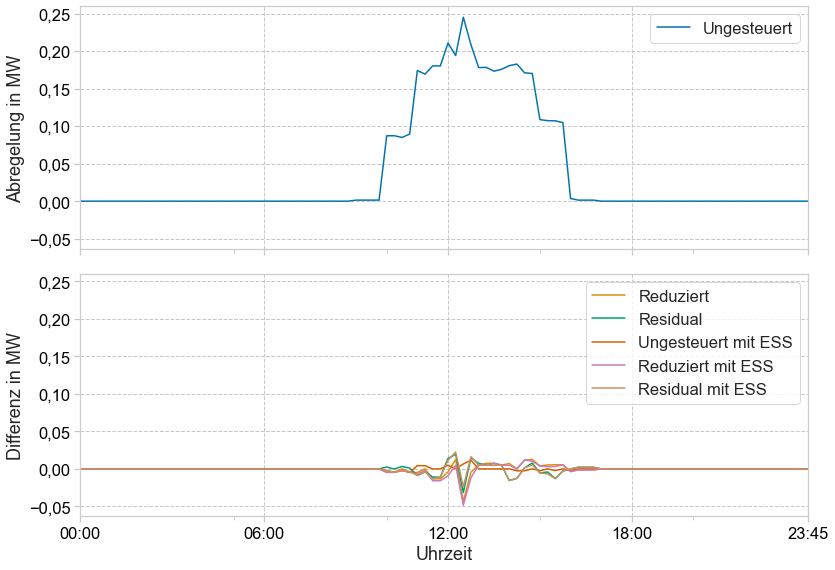

In [18]:
plot_tuples = [
    (curtailment_dir, strategy)
    for curtailment_dir in curtailment_dirs
    for strategy in strategies]

index = pd.date_range("2018-01-01", periods=7, freq="1D")
index = [ts.strftime("%A") for ts in index]

columns = [date.strftime("%H:%M") for date in pd.date_range(
            "2018-01-01", periods=96, freq="15Min")]

# the index of the position of yticks
xticks = [0, 24, 48, 72, 95]

xticklabels = [columns[idx] for idx in xticks]

palette = sns.color_palette("colorblind")

for grid_id in grid_ids:
    grid_df = results_df.loc[:, idx[:, grid_id, :, :]]
    
    base_case_sli = grid_df.iloc[:, :2].to_numpy()
    
    grid_df.iloc[:, 2:] -= np.tile(
        grid_df.iloc[:, :2].to_numpy(), (1, 5))
    
    for week in weeks:
        week_df = grid_df.loc[
            :, idx[:, :, :, week]]

        fig, axs = plt.subplots(
            2, 1, figsize=standard_sizes["a4landscape"], sharex=True, sharey=True)
        
        day_df = pd.DataFrame(
            columns=week_df.columns, dtype="float64")

        for i in range(4*24):
            sli = week_df.iloc[i::4*24, :].mean().tolist()

            day_df.loc[i] = sli
            
        for count, ax in enumerate(axs):
            if count == 0:
                plt_df = day_df.iloc[:, :1]
                colormap = ListedColormap(palette.as_hex())
            else:
                plt_df = day_df.iloc[:, 1:]
                colormap = ListedColormap(palette.as_hex()[1:6])
                            
            plt_df.plot.line(
                ax=ax, colormap=colormap)
            
            # legend
            handles, labels = ax.get_legend_handles_labels()
            
            labels = ["".join(label.split("(")[-1].split(", ")[0::2]) for label in labels]
            
            labels = [legend_dict[label] for label in labels]
            
            ax.legend(handles, labels)
            
            # xticks and xlim
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            
            ax.set_xlim((0, 95))
            
            if count == 0:
                ax.set_ylabel("Abregelung in MW")
            else:
                ax.set_xlabel("Uhrzeit")
                ax.set_ylabel("Differenz in MW")
            
        fig.align_ylabels()
        plt.tight_layout()
        
        for kind in figure_export_as:
            plt.savefig(
                os.path.join(export_dir, f"{grid_id}_{week}_fee_curtailment_line_plot.{kind}"),
                dpi=450, bbox_inches="tight")

        plt.show()
        

### Loads

In [19]:
file = "{}_curtailment_ts_per_load.csv"

In [20]:
idx = pd.IndexSlice

results_loads_df = pd.DataFrame(
    index=[*range(672)], columns=pd.MultiIndex.from_tuples(scenario_tuples))

for curtailment_dir, grid_id, strategy, week in tqdm(scenario_tuples):
    # data dirs
    cur_dir = base_dir.format(
        curtailment_dir, grid_id, strategy)
    
    # curtailment file
    cur_f = file.format(week)
    
    cur_s = pd.read_csv(os.path.join(
        cur_dir, cur_f), index_col=0, parse_dates=True).sum(
        axis=1).tolist()
        
    results_loads_df.loc[
        :, idx[curtailment_dir, grid_id, strategy, week]] = cur_s

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [01:04<00:00,  1.12it/s]


In [21]:
results_loads_df.head()

curtailment_results_weekly                                                   \
                        176                                              177    
                        dumb        reduced         residual             dumb   
                      max_rl min_rl  max_rl min_rl    max_rl min_rl    max_rl   
0                        0.0    0.0     0.0    0.0  0.000000    0.0  0.560760   
1                        0.0    0.0     0.0    0.0  0.000000    0.0  0.554208   
2                        0.0    0.0     0.0    0.0  0.000000    0.0  0.554208   
3                        0.0    0.0     0.0    0.0  0.000000    0.0  0.574466   
4                        0.0    0.0     0.0    0.0  0.124776    0.0  0.637737   

                                 ...  \
                                 ...   
              reduced            ...   
     min_rl    max_rl    min_rl  ...   
0  0.591276  0.561290  0.592435  ...   
1  0.643147  0.554718  0.649814  ...   
2  0.553749  0.554718  0.554524  ...   
3  0.553749  0.575032  0.554524  ...   
4  0.553415  0.639715  0.554190  ...   

  curtailment_results_weekly_with_solar_storage                          \
                                           1811                           
                                        reduced        residual           
                                         max_rl min_rl   max_rl  min_rl   
0                                           0.0    0.0      0.0  0.0000   
1                                           0.0    0.0      0.0  0.0000   
2                                           0.0    0.0      0.0  0.0011   
3                                           0.0    0.0      0.0  0.0000   
4                                           0.0    0.0      0.0  0.0000   

                                                
    2534                                        
    dumb        reduced        residual         
  max_rl min_rl  max_rl min_rl   max_rl min_rl  
0    0.0    0.0     0.0    0.0      0.0    0.0  
1    0.0    0.0     0.0    0.0      0.0    0.0  
2    0.0    0.0     0.0    0.0      0.0    0.0  
3    0.0    0.0     0.0    0.0      0.0    0.0  
4    0.0    0.0     0.0    0.0      0.0    0.0  

[5 rows x 72 columns]

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


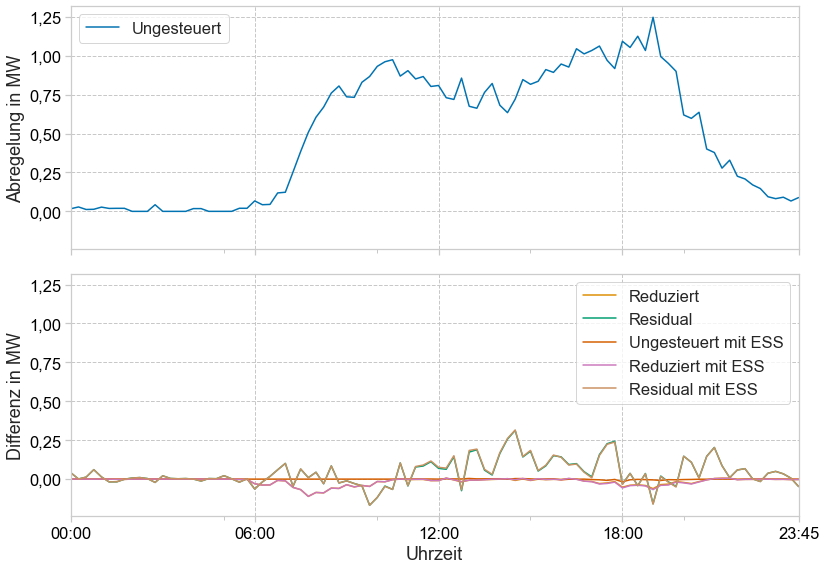

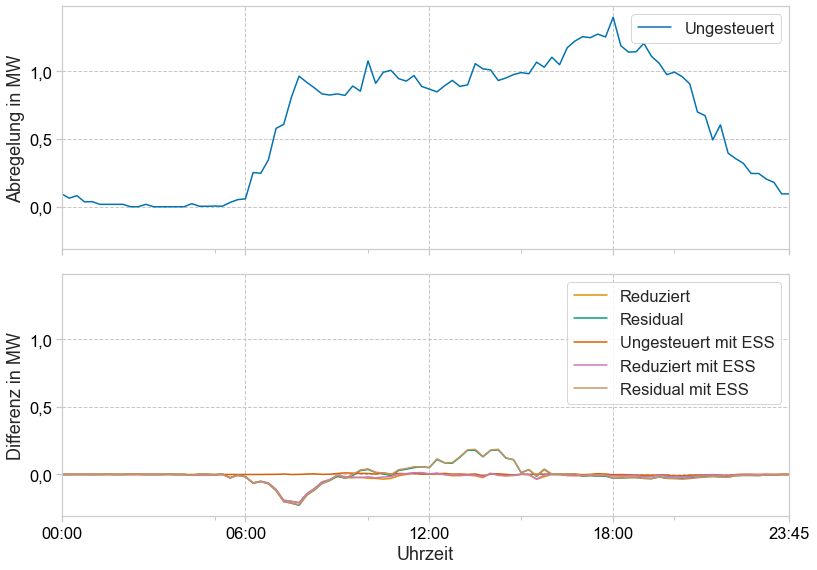

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


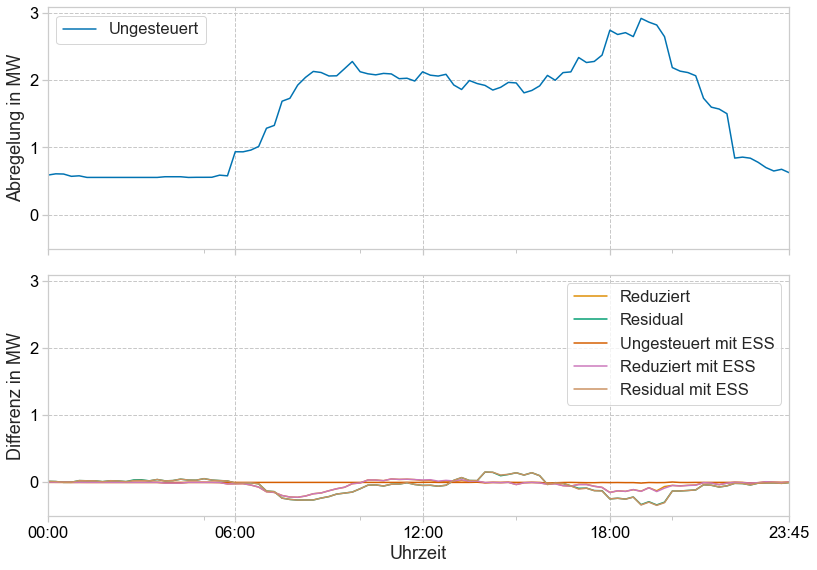

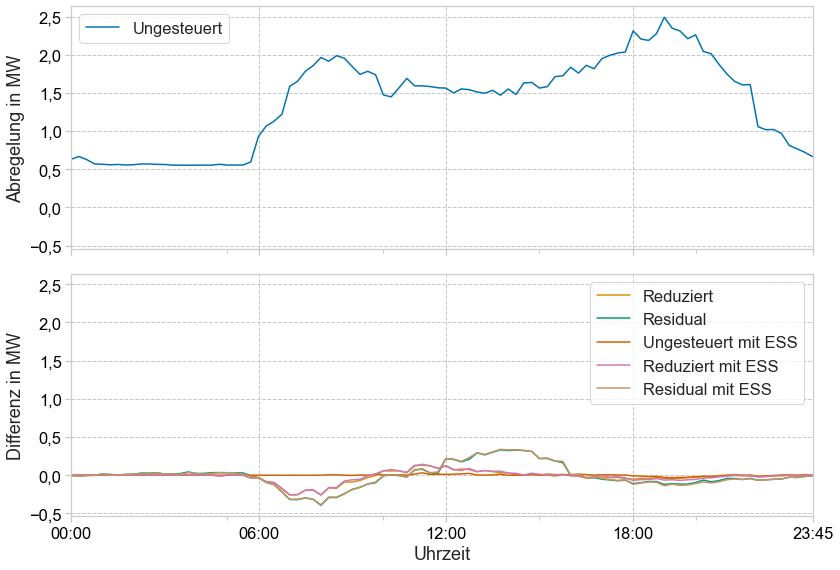

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


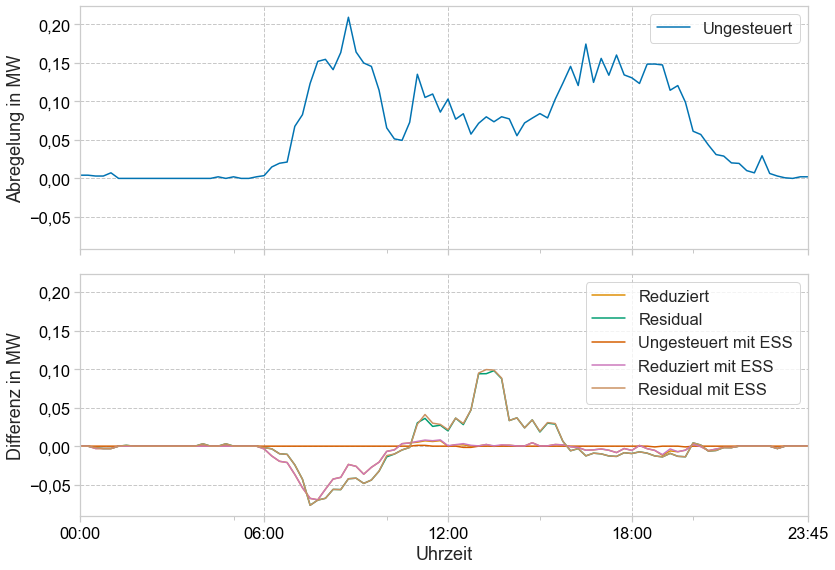

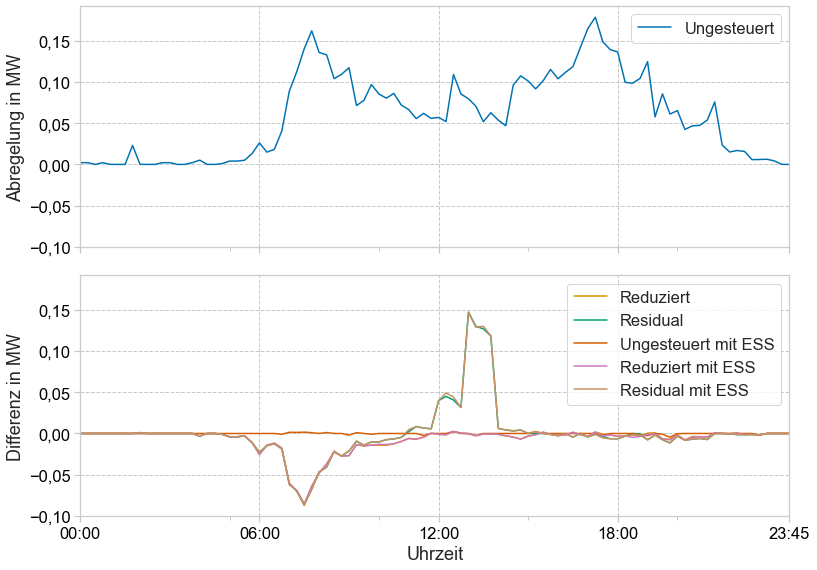

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


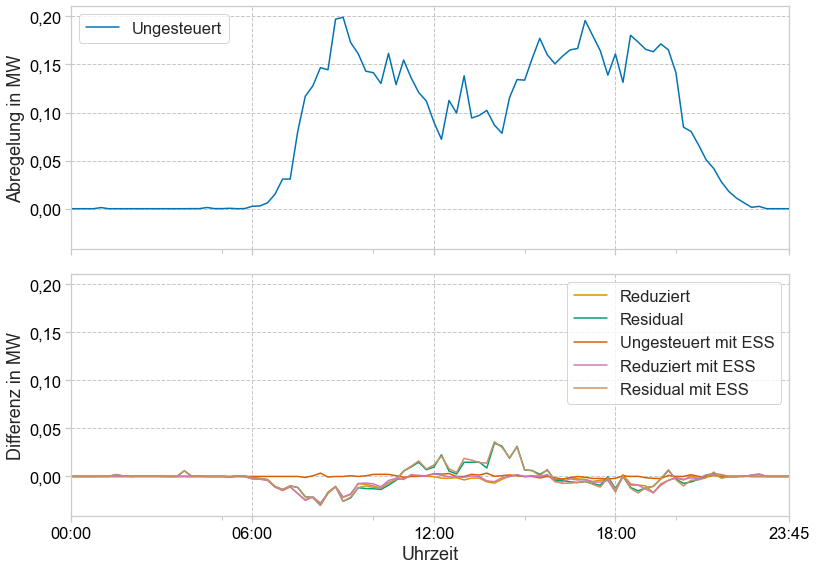

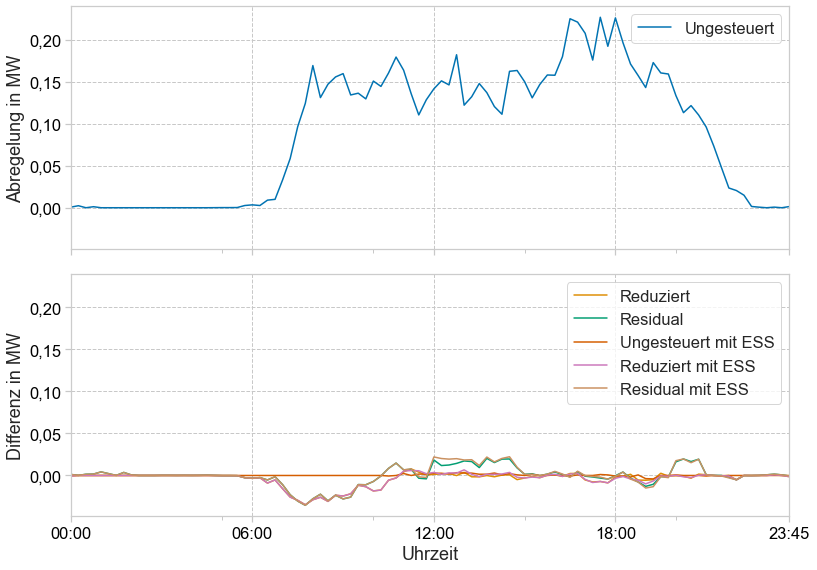

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


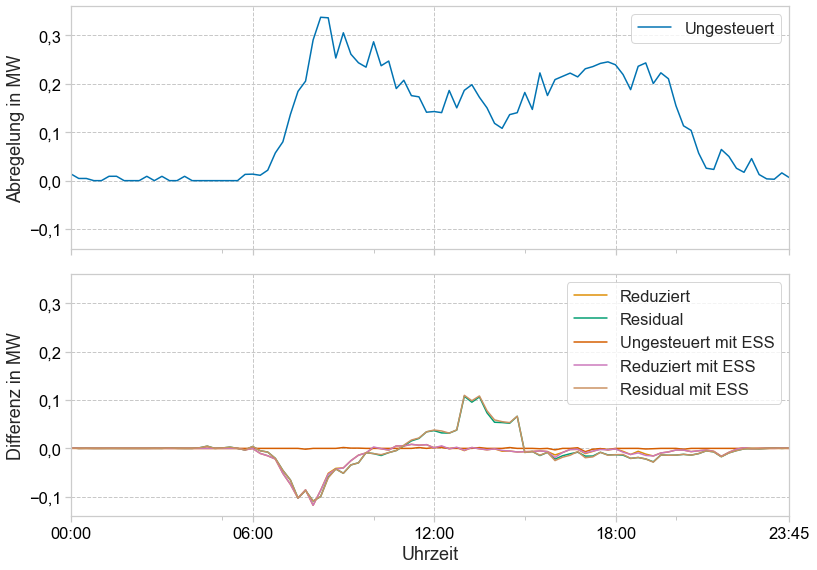

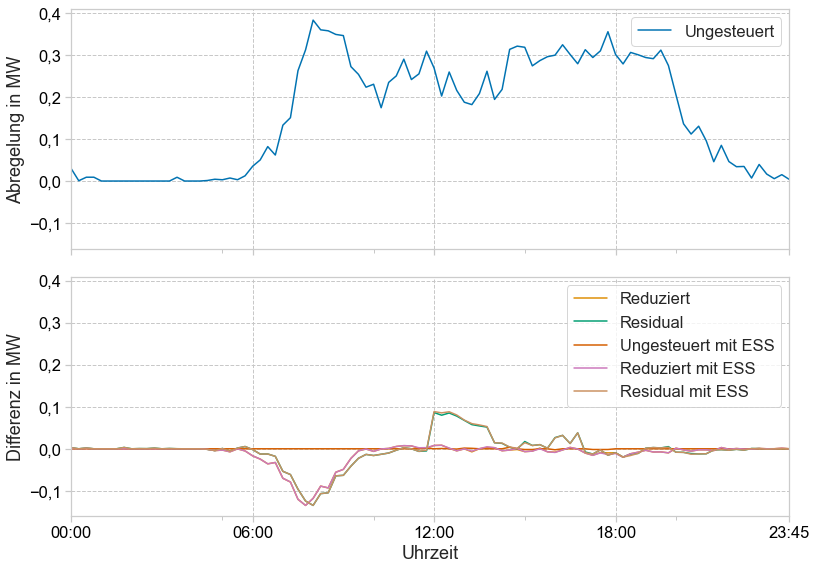

/home/kilian/Documents/virtualenvs/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


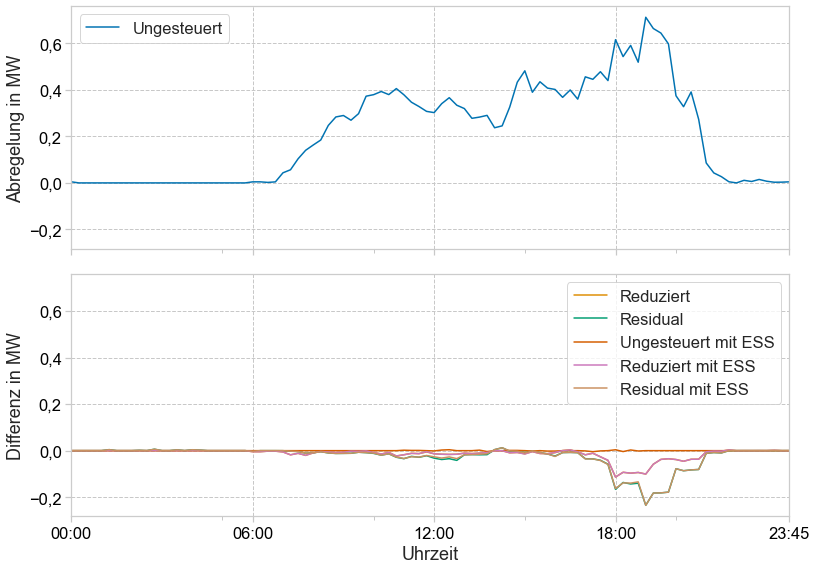

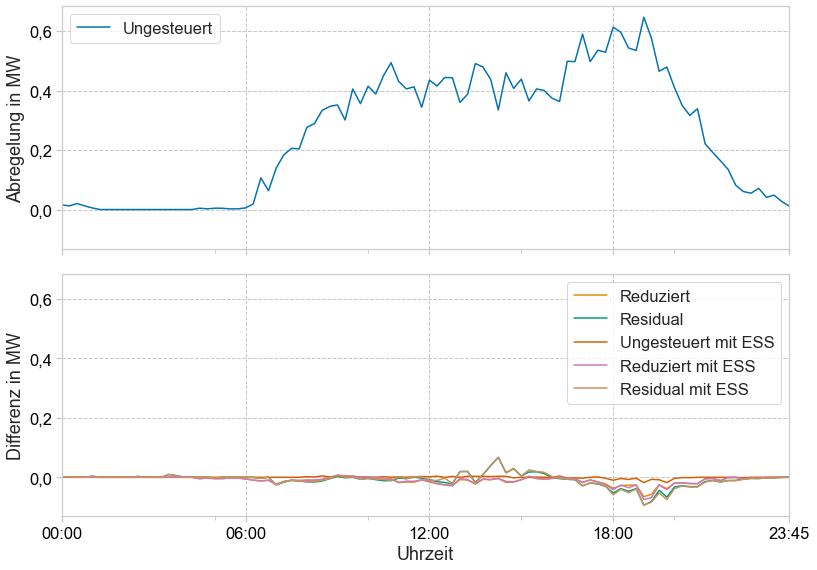

In [22]:
plot_tuples = [
    (curtailment_dir, strategy)
    for curtailment_dir in curtailment_dirs
    for strategy in strategies]

index = pd.date_range("2018-01-01", periods=7, freq="1D")
index = [ts.strftime("%A") for ts in index]

columns = [date.strftime("%H:%M") for date in pd.date_range(
            "2018-01-01", periods=96, freq="15Min")]

# the index of the position of yticks
xticks = [0, 24, 48, 72, 95]

xticklabels = [columns[idx] for idx in xticks]

palette = sns.color_palette("colorblind")

for grid_id in grid_ids:
    grid_df = results_loads_df.loc[:, idx[:, grid_id, :, :]]
    
    base_case_sli = grid_df.iloc[:, :2].to_numpy()
    
    grid_df.iloc[:, 2:] -= np.tile(
        grid_df.iloc[:, :2].to_numpy(), (1, 5))
    
    for week in weeks:
        week_df = grid_df.loc[
            :, idx[:, :, :, week]]

        fig, axs = plt.subplots(
            2, 1, figsize=standard_sizes["a4landscape"], sharex=True, sharey=True)
        
        day_df = pd.DataFrame(
            columns=week_df.columns, dtype="float64")

        for i in range(4*24):
            sli = week_df.iloc[i::4*24, :].mean().tolist()

            day_df.loc[i] = sli
            
        for count, ax in enumerate(axs):
            if count == 0:
                plt_df = day_df.iloc[:, :1]
                colormap = ListedColormap(palette.as_hex())
            else:
                plt_df = day_df.iloc[:, 1:]
                colormap = ListedColormap(palette.as_hex()[1:6])
                            
            plt_df.plot.line(
                ax=ax, colormap=colormap)
            
            # legend
            handles, labels = ax.get_legend_handles_labels()
            
            labels = ["".join(label.split("(")[-1].split(", ")[0::2]) for label in labels]
            
            labels = [legend_dict[label] for label in labels]
            
            ax.legend(handles, labels)
            
            # xticks and xlim
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            
            ax.set_xlim((0, 95))
            
            if count == 0:
                ax.set_ylabel("Abregelung in MW")
            else:
                ax.set_xlabel("Uhrzeit")
                ax.set_ylabel("Differenz in MW")
            
        fig.align_ylabels()
        plt.tight_layout()
        
        for kind in figure_export_as:
            plt.savefig(
                os.path.join(export_dir, f"{grid_id}_{week}_load_curtailment_line_plot.{kind}"),
                dpi=450, bbox_inches="tight")

        plt.show()
        